#Data pre-processing

In [126]:
import pandas as pd
import numpy as np
import io
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).





##Inspecting the Dataset



---




In [127]:
# Load Datase
path = "/content/drive/My Drive/data/marketing_campaign.csv"
df = pd.read_csv(path, sep='\t') 

# view column names, non-null count and dtype
print(df.info()) 

# view the first 5 rows
pd.set_option('display.max_columns', None)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0




## 1. Data preprocessing/cleaning
---


### Handle missing values

*After inspecting the dataset with df.info(), we found that only the Income column has missing values.*

In [128]:
print("Total Income missing values:" , df.Income.isnull().sum())

Total Income missing values: 24


*As there are only a small number of missing values (24 out of 2240 rows), we can safely remove the rows with missing values to avoid any potential bias or errors in our analysis.*

In [129]:
df.dropna(subset=['Income'], inplace=True)
print("Total Income missing values:" , df.Income.isnull().sum())

Total Income missing values: 0


### Handle dates

Convert the Dt_Customer column from object type to datetime format.This allows us to perform time-based analysis on customer acquisition *dates*

In [130]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Dt_Customer']

<ipython-input-130-1631629796dd>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


0      2012-04-09
1      2014-08-03
2      2013-08-21
3      2014-10-02
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-10-06
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: Dt_Customer, Length: 2216, dtype: datetime64[ns]

## 2. Marital_Status , Education
---


*Inspect columns*

In [131]:
print("Unique values in Marital_Status:","\n", df['Marital_Status'].unique())
print("\n","Unique values in Education: ","\n", df['Education'].unique())

Unique values in Marital_Status: 
 ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']

 Unique values in Education:  
 ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


*Simplify the categories for Education*

In [132]:
df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
print("Unique values in Marital_Status:","\n", df['Marital_Status'].unique())

Unique values in Marital_Status: 
 ['Single' 'Together' 'Married' 'Divorced' 'Widow']


### Distribution of marital status and education

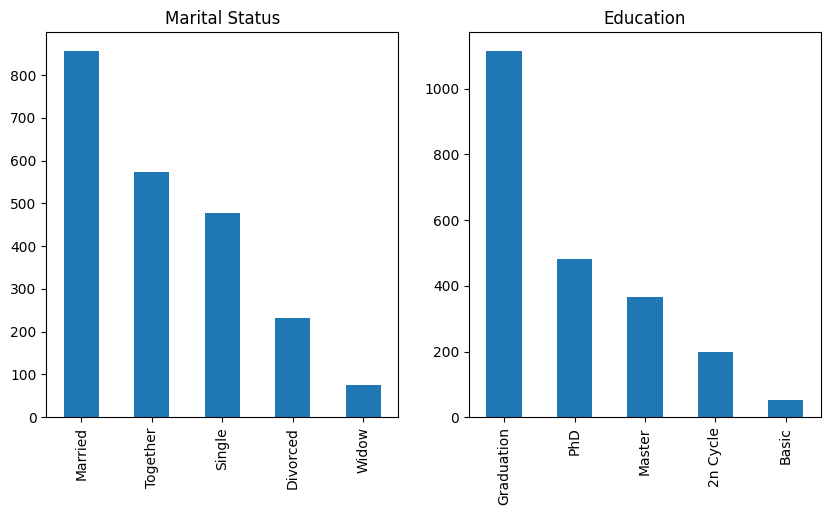

In [133]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))

df['Marital_Status'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Marital Status')

df['Education'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Education')

plt.show()

## 3.  Creating new **features** based on customer behavior
---


### A. **Customer_for**: Days since first and last purchase

In [134]:
import datetime as dt

def calculate_customer_for(customer):

    today = pd.Timestamp.today().normalize()
    first_purchase = pd.to_datetime(customer['Dt_Customer']).normalize()
    #Days passed since latest purchase
    recency = dt.timedelta(days=customer['Recency'])
    return (today - recency - first_purchase).days

df['Customer_For'] = df.apply(calculate_customer_for, axis=1)

df[['Dt_Customer', 'Recency', 'Customer_For']].head(3)

,Dt_Customer,Recency,Customer_For
0,2012-04-09,58,3970
1,2014-08-03,38,3144
2,2013-08-21,26,3503


### B. **Age**: Calculation of Customer Age based on Year of Birth

In [135]:
def calculate_age(year_birth):
    current_year = dt.datetime.now().year
    age = current_year - year_birth
    return age

df['Age'] = df['Year_Birth'].apply(calculate_age)
df[['Year_Birth', 'Age']].head(3)

,Year_Birth,Age
0,1957,66
1,1954,69
2,1965,58


### C. **Spend**: Calculation of Total Amount Spent by Customer in a Two-Year Period

In [136]:
df['Spent'] = df.loc[:, 'MntWines':'MntGoldProds'].sum(axis=1)
df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Spent']].head(2)

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Spent
0,635,88,546,172,88,88,1617
1,11,1,6,2,1,6,27


### D. **Children**: Total number of children in a household, including both kids and teenagers

In [137]:
df['Children'] = df['Kidhome'] + df['Teenhome']
df[['Kidhome', 'Teenhome', 'Children']].head(2)

,Kidhome,Teenhome,Children
0,0,0,0
1,1,1,2


### E. **Family_Size**: Calculate Family Size based on Marital Status and Number of Children

In [138]:
def calculate_family_size(row):
    # Case for 2 adults
    if row['Marital_Status'] == 'Together' or row['Marital_Status'] == 'Married':
        return row['Children'] + 2 
    # Case for 1 adult
    else:
        return row['Children'] + 1 

df['Family_Size'] = df.apply(calculate_family_size, axis=1)

df[['Marital_Status', 'Children', 'Family_Size']].head()

,Marital_Status,Children,Family_Size
0,Single,0,1
1,Single,2,3
2,Together,0,2
3,Together,1,3
4,Married,1,3


### F. **Is_Parent**: Based on the "children" column

In [139]:
df['Is_Parent'] = df['Children'] > 0
df['Is_Parent'] = df['Is_Parent'].astype(int)
df[['Children', 'Is_Parent']].head(2)

,Children,Is_Parent
0,0,0
1,2,1


### G. **Living_With**: Based on Marital_Status

In [140]:
df['Living_With'] = df['Marital_Status'].apply(lambda x: "Partner" if x in ['Married', 'Together'] else "Alone")

df[['Marital_Status', 'Living_With']].head()

,Marital_Status,Living_With
0,Single,Alone
1,Single,Alone
2,Together,Partner
3,Together,Partner
4,Married,Partner


### H. **Age_Group**: Based on Age Group

In [141]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['<20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80']

df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df[['Age', 'Age_Group']].head()

,Age,Age_Group
0,66,61-70
1,69,61-70
2,58,51-60
3,39,31-40
4,42,41-50


## 4. Check for extreme values


---



*After inspecting the data for max, min, and NaN values, we found that there were three customers with an age of 120+ who had made recent purchases. Given that it is highly unusual for customers to be active at such an advanced age, we have decided to remove these entries from our dataset, assuming that they are extreme values. As a result, we have removed the three entries with ages greater than or equal to 120.*

In [142]:
df.loc[df['Age'] > 80, ['Age', 'Recency', 'Dt_Customer' ]]

,Age,Recency,Dt_Customer
192,123,99,2013-09-26
239,130,23,2014-05-17
339,124,36,2013-09-26
424,82,77,2013-04-13
1950,83,96,2013-08-07


In [143]:
#Remove extreme values
max_age_indices = df['Age'].nlargest(3).index
df = df.drop(max_age_indices)
df.loc[df['Age'] > 80, ['Age', 'Recency', 'Dt_Customer' ]]

,Age,Recency,Dt_Customer
424,82,77,2013-04-13
1950,83,96,2013-08-07


In [144]:
print(df.info()) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213 entries, 0 to 2239
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2213 non-null   int64         
 1   Year_Birth           2213 non-null   int64         
 2   Education            2213 non-null   object        
 3   Marital_Status       2213 non-null   object        
 4   Income               2213 non-null   float64       
 5   Kidhome              2213 non-null   int64         
 6   Teenhome             2213 non-null   int64         
 7   Dt_Customer          2213 non-null   datetime64[ns]
 8   Recency              2213 non-null   int64         
 9   MntWines             2213 non-null   int64         
 10  MntFruits            2213 non-null   int64         
 11  MntMeatProducts      2213 non-null   int64         
 12  MntFishProducts      2213 non-null   int64         
 13  MntSweetProducts     2213 non-nul

## 5. Exploring the Correlation between Numeric Features using Heatmap


---


<Axes: >

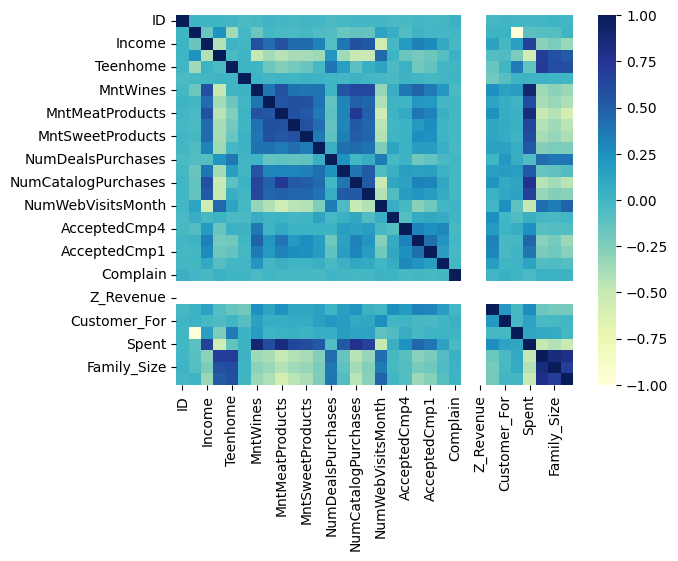

In [146]:
import seaborn as sns

num_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()
# create the correlation matrix
corr_matrix = df[num_cols].corr()

# plot the heatmap
sns.heatmap(corr_matrix, cmap="YlGnBu")
